##Premier modèle :: LSTM (tensorflow)

### Lire les données

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [ ]:
sns.set_style("darkgrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/inrae/icos/preprocessed_dataICOS.csv')
# data = pd.read_csv('../data/preprocessed_dataICOS.csv') si téléchargé depuis github
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.head()

,Unnamed: 0,station.name,DateTime,Tair,Rg,NEE_F,NEE_F_QC,GPP,VPD,P,...,SWC50cm,SWC_3,GPP_ann,GPP_cycle,anomalies,Time (s),cos day,sin day,cos year,sin year
0,1,FR-Bil,2014-01-01 00:30:00,8.725,0.0,9.42146,3,-4.35020,0.005,0.0,...,NaN,NaN,0.032499,-3.676288,-0.706411,0.0,1.000000,0.000000,1.000000,0.000000
1,2,FR-Bil,2014-01-01 01:00:00,8.664,0.0,8.30763,3,-3.25360,0.000,0.0,...,NaN,NaN,0.092393,-2.138151,-1.207841,1800.0,0.991445,0.130526,1.000000,0.000359
2,3,FR-Bil,2014-01-01 01:30:00,8.402,0.0,8.52988,3,-3.54959,0.000,0.0,...,NaN,NaN,0.050926,-2.455661,-1.144855,3600.0,0.965926,0.258819,1.000000,0.000717
3,4,FR-Bil,2014-01-01 02:00:00,8.474,0.0,8.78492,3,-3.78440,0.000,0.0,...,NaN,NaN,-0.453788,-2.820244,-0.510367,5400.0,0.923880,0.382683,0.999999,0.001076
4,5,FR-Bil,2014-01-01 02:30:00,8.507,0.0,7.94900,3,-2.93920,0.000,0.0,...,NaN,NaN,-0.586342,-2.526737,0.173879,7200.0,0.866025,0.500000,0.999999,0.001435


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120432 entries, 0 to 120431
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    120432 non-null  int64         
 1   station.name  120432 non-null  object        
 2   DateTime      120432 non-null  datetime64[ns]
 3   Tair          120432 non-null  float64       
 4   Rg            120432 non-null  float64       
 5   NEE_F         120432 non-null  float64       
 6   NEE_F_QC      120432 non-null  int64         
 7   GPP           120432 non-null  float64       
 8   VPD           120432 non-null  float64       
 9   P             120432 non-null  float64       
 10  LE_F          120432 non-null  float64       
 11  RECO          120432 non-null  float64       
 12  SWC10cm       110907 non-null  float64       
 13  SWC20cm       110906 non-null  float64       
 14  SWC50cm       108150 non-null  float64       
 15  SWC_3         111

### Préparation des données & helper functions

In [ ]:
df = data[['GPP_ann', 'GPP_cycle', 'anomalies', 'cos day','sin day','cos year', 'sin year']]
df.head()

,GPP_ann,GPP_cycle,anomalies,cos day,sin day,cos year,sin year
0,0.032499,-3.676288,-0.706411,1.000000,0.000000,1.000000,0.000000
1,0.092393,-2.138151,-1.207841,0.991445,0.130526,1.000000,0.000359
2,0.050926,-2.455661,-1.144855,0.965926,0.258819,1.000000,0.000717
3,-0.453788,-2.820244,-0.510367,0.923880,0.382683,0.999999,0.001076
4,-0.586342,-2.526737,0.173879,0.866025,0.500000,0.999999,0.001435


In [ ]:
"""
fonction qui à partir du dataframe, crée des séquences sous forme de
[ [GPP_ann(t-L),GPP_cycle(t-L),anomalies(t-L),+time(t-L)], [GPP_ann(t-L+1),GPP_cycle(t-L+1),anomalies(t-L+1),+time(t-L+1)], ... ,
[GPP_ann(t),GPP_cycle(t),anomalies(t),+time(t)] ]
et des targets à t+1 : [GPP_ann(t+1), GPP_cycle(t+1), anomalies(t+1)]
avec L : longueur choisie de la séquence
l'intérêt d'avoir 3 sorties est d'évaluer chaque composante individuellemnt
"""
def inputs_outputs(sequence_length, data):
    data = np.array(data)
    sequences = []
    targets = []
    for i in range(0,len(data)-sequence_length-1):
        sequence = data[i:i+sequence_length] # variables d'intérêt de (t-L) à t + 4 remaining features(time), [GPP_ann,GPP_cycle,anomalies,+time ]
        target = data[i+sequence_length][:3] # variables d'intérêt à t+1 # [GPP_ann(t+1), GPP_cycle(t+1), anomalies(t+1)]
        sequences.append(sequence)
        targets.append(target)
    sequences = np.array(sequences)
    targets = np.array(targets)

    return sequences, targets

In [ ]:
sequence_length=365 # 7 jours
sequences, targets = inputs_outputs(sequence_length, df)

In [ ]:
sequences[0], targets[0]

(array([[ 3.24989500e-02, -3.67628790e+00, -7.06411050e-01, ...,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
        [ 9.23926000e-02, -2.13815121e+00, -1.20784139e+00, ...,
          1.30526192e-01,  9.99999936e-01,  3.58629291e-04],
        [ 5.09260000e-02, -2.45566127e+00, -1.14485473e+00, ...,
          2.58819045e-01,  9.99999743e-01,  7.17258535e-04],
        ...,
        [ 5.72043500e+00,  3.63141000e+00,  9.50655500e+00, ...,
         -2.58819045e-01,  9.91584719e-01,  1.29459433e-01],
        [ 8.76057000e+00,  2.22377071e+00,  1.84405929e+00, ...,
         -3.82683432e-01,  9.91538227e-01,  1.29815036e-01],
        [ 7.01971500e+00,  2.41486857e+00,  3.46391643e+00, ...,
         -5.00000000e-01,  9.91491608e-01,  1.30170623e-01]]),
 array([8.694505  , 3.03343071, 1.07246429]))

In [ ]:
sequences.shape, targets.shape #seq_len=365, features=7

((120066, 365, 7), (120066, 3))

In [ ]:
# diviser le dataset en données d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=19)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96052, 365, 7), (24014, 365, 7), (96052, 3), (24014, 3))

In [ ]:
import tensorflow.keras.backend as K

def weighted_loss(weights_matrix):
    def loss(y_true, y_pred):
        weighted_error = K.square(y_true - y_pred)*weights_matrix # choisir les composantes à prendre en compte et les composantes à ignorer (matrice binaire)
        return K.mean(weighted_error) # mse
    return loss

In [ ]:
weights_matrix_ann = [[1, 0, 0]]    # tenir compte de la composante annuelle
weights_matrix_cycle = [[0, 1, 0]]  # ............................. cycle
weights_matrix_anomalies = [[0, 0, 1]] # .......................... anomalies

# fonctions de loss personnalisés (pondérées)
loss_ann = weighted_loss(weights_matrix_ann)
loss_cycle = weighted_loss(weights_matrix_cycle)
loss_anomalies = weighted_loss(weights_matrix_anomalies)

## Modèle

 ### LSTM Tensorflow

In [ ]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def mymodel(hidden_units, sequence_length, features, nbr_sorties):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(sequence_length,features), kernel_initializer='he_normal')) # initialisation poids: distribution normale he
    model.add(Dense(nbr_sorties))
    return model

In [ ]:
nbr_sorties = 3
hidden_units = 128
sequence_length = 365
features = 7
tf_model = mymodel(hidden_units, sequence_length, features, nbr_sorties)
tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 70,019
Trainable params: 70,019
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# hyperparamètres
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
#n_epochs = 100
batch_size = 32

In [ ]:
# arrêter l'entrainement si 5 epochs s'écoulent sans amélioration (pour éviter le over-fitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

#### Erreur sur la composante annuelle

In [ ]:
tf_model_ann = mymodel(hidden_units, sequence_length, features, nbr_sorties)

In [ ]:
tf_model_ann.compile(optimizer=optimizer, loss=loss_ann)

In [ ]:
history_ann = tf_model_ann.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
3002/3002 [==============================] - 46s 15ms/step - loss: 1.4071 - val_loss: 0.8702
Epoch 2/100
3002/3002 [==============================] - 43s 14ms/step - loss: 0.8382 - val_loss: 0.8346
Epoch 3/100
3002/3002 [==============================] - 43s 14ms/step - loss: 0.8108 - val_loss: 0.8680
Epoch 4/100
3002/3002 [==============================] - 53s 18ms/step - loss: 0.7958 - val_loss: 0.8178
Epoch 5/100
3002/3002 [==============================] - 45s 15ms/step - loss: 0.7844 - val_loss: 0.7946
Epoch 6/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.7795 - val_loss: 0.7974
Epoch 7/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.7729 - val_loss: 0.7946
Epoch 8/100
3002/3002 [==============================] - 44s 15ms/step - loss: 0.7693 - val_loss: 0.8001
Epoch 9/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.7619 - val_loss: 0.7807
Epoch 10/100
3002/3002 [==============================]

In [ ]:
tf_model_ann.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_ann.h5')

#### Erreur sur la composante du cycle

In [ ]:
tf_model_cycle = mymodel(hidden_units, sequence_length, features, nbr_sorties)

In [ ]:
tf_model_cycle.compile(optimizer=optimizer, loss=loss_cycle)

In [ ]:
history_cycle = tf_model_cycle.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
3002/3002 [==============================] - 45s 14ms/step - loss: 0.5956 - val_loss: 0.5107
Epoch 2/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.4623 - val_loss: 0.5006
Epoch 3/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.4114 - val_loss: 0.4225
Epoch 4/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3858 - val_loss: 0.3845
Epoch 5/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3639 - val_loss: 0.3798
Epoch 6/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3603 - val_loss: 0.3706
Epoch 7/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3512 - val_loss: 0.3843
Epoch 8/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3397 - val_loss: 0.3739
Epoch 9/100
3002/3002 [==============================] - 42s 14ms/step - loss: 0.3344 - val_loss: 0.3626
Epoch 10/100
3002/3002 [==============================]

In [ ]:
tf_model_cycle.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_cycle.h5')

#### Erreur sur les anomalies

In [ ]:
tf_model_anomalies = mymodel(hidden_units, sequence_length, features, nbr_sorties)

In [ ]:
tf_model_anomalies.compile(optimizer=optimizer, loss=loss_anomalies)

In [ ]:
history_anomalies = tf_model_anomalies.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
3002/3002 [==============================] - 57s 17ms/step - loss: 2.6870 - val_loss: 2.5807
Epoch 2/100
3002/3002 [==============================] - 47s 16ms/step - loss: 2.5405 - val_loss: 2.5789
Epoch 3/100
3002/3002 [==============================] - 46s 15ms/step - loss: 2.5091 - val_loss: 2.5673
Epoch 4/100
3002/3002 [==============================] - 45s 15ms/step - loss: 2.4811 - val_loss: 2.5649
Epoch 5/100
3002/3002 [==============================] - 46s 15ms/step - loss: 2.4504 - val_loss: 2.5665
Epoch 6/100
3002/3002 [==============================] - 45s 15ms/step - loss: 2.4160 - val_loss: 2.5834
Epoch 7/100
3002/3002 [==============================] - 45s 15ms/step - loss: 2.3832 - val_loss: 2.5909
Epoch 8/100
3002/3002 [==============================] - 46s 15ms/step - loss: 2.3463 - val_loss: 2.5934
Epoch 9/100
3002/3002 [==============================] - 47s 16ms/step - loss: 2.3103 - val_loss: 2.6132


In [ ]:
tf_model_anomalies.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_anomalies.h5')

### Courbes loss

#### Cross year average

In [ ]:
train_loss = history_ann.history['loss']
val_loss = history_ann.history['val_loss']

In [ ]:
data_ann = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})
data_ann.head()

,Epochs,Training Loss,Validation Loss
0,1,1.407084,0.870183
1,2,0.838185,0.834567
2,3,0.810821,0.867958
3,4,0.795828,0.817820
4,5,0.784361,0.794628


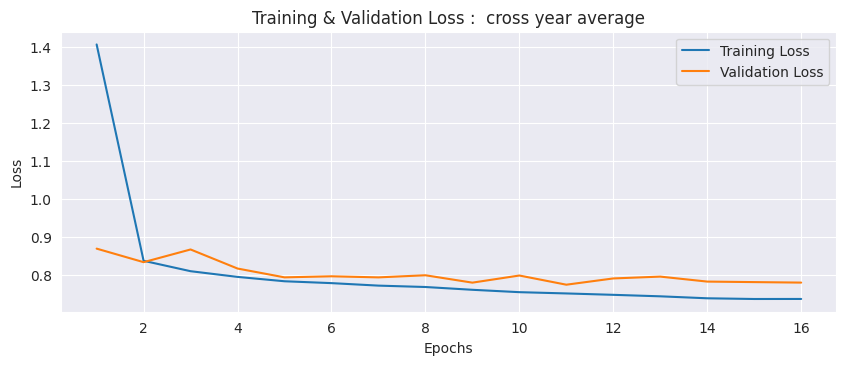

In [ ]:
plt.figure(figsize=(10, 8))

#Courbes loss, training vs validation
plt.subplot(2, 1, 1)
sns.lineplot(data=data_ann, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_ann, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  cross year average')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### day-and-night cycle

In [ ]:
train_loss = history_cycle.history['loss']
val_loss = history_cycle.history['val_loss']

data_cycle = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

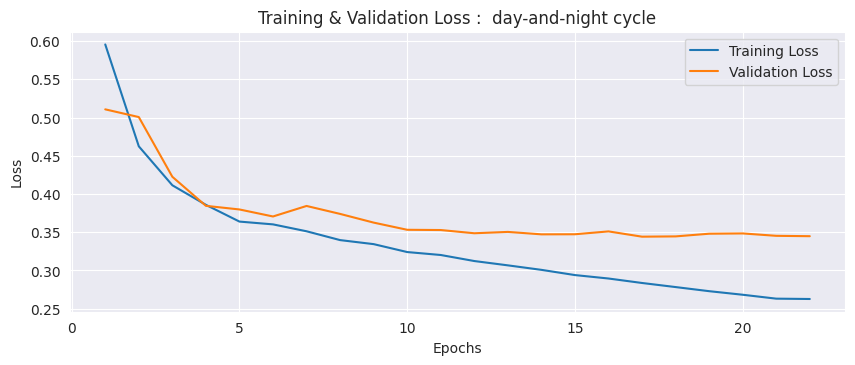

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_cycle, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_cycle, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  day-and-night cycle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### anomalies

In [ ]:
train_loss = history_anomalies.history['loss']
val_loss = history_anomalies.history['val_loss']

data_anomalies = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

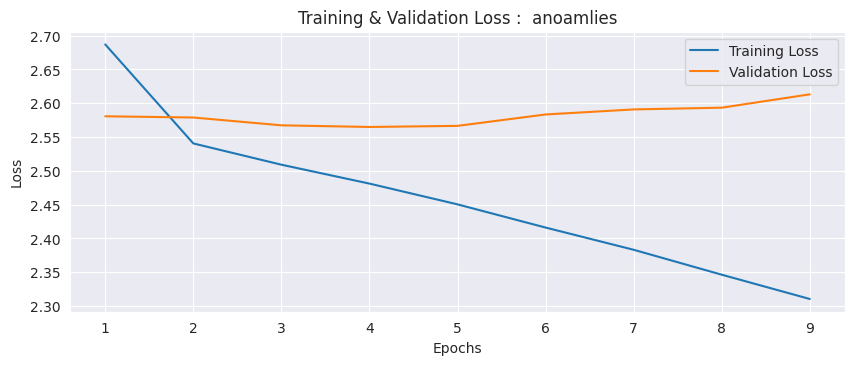

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_anomalies, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_anomalies, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  anoamlies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Continuer l'entrainement

La dernière fois, j'ai lancé les différents entrainements sur 100 époques en utilisant un critère d'arrêt prématuré (early-stopping) lorsque les performances (évaluées sur l'ensemble de validation) ne progressent plus. Maintenant, je vais poursuivre l'entraînement de ces modèles, mais cette fois avec une patience de 30. Les modèles enregistrés précédemment ont été entraînés respectivement sur 16 époques (pour l'erreur sur la composante annuelle), 22 époques (pour l'erreur sur le cycle) et 9 époques (pour l'erreur sur les anomalies).

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

#### Erreur sur la composante annuelle

In [ ]:
tf_model_ann = tf.keras.models.load_model('/content/drive/MyDrive/inrae/mymodels/tf_lstm_ann.h5',custom_objects={'loss': loss_ann})

In [ ]:
tf_model_ann.compile(optimizer=optimizer, loss=loss_ann)

In [ ]:
history_ann = tf_model_ann.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping],verbose=0)

In [ ]:
train_loss = history_ann.history['loss']
val_loss = history_ann.history['val_loss']

data_ann = pd.DataFrame({'Epochs': range(17, len(train_loss)+17),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

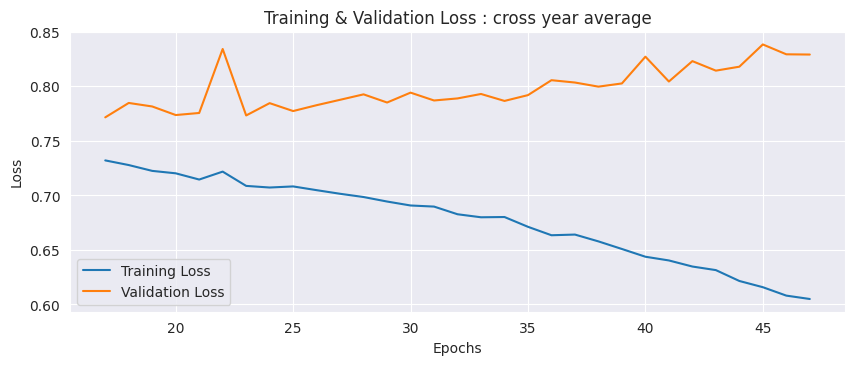

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_ann, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_ann, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss : cross year average')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
tf_model_ann.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_ann_47ep.h5')

#### Erreur sur la composante du cycle

In [ ]:
tf_model_cycle = tf.keras.models.load_model('/content/drive/MyDrive/inrae/mymodels/tf_lstm_cycle.h5',custom_objects={'loss': loss_cycle})

In [ ]:
tf_model_cycle.compile(optimizer=optimizer, loss=loss_cycle)

In [ ]:
history_cycle = tf_model_cycle.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping], verbose=0)

In [ ]:
train_loss = history_cycle.history['loss']
val_loss = history_cycle.history['val_loss']

data_cycle = pd.DataFrame({'Epochs': range(23, len(train_loss)+23),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

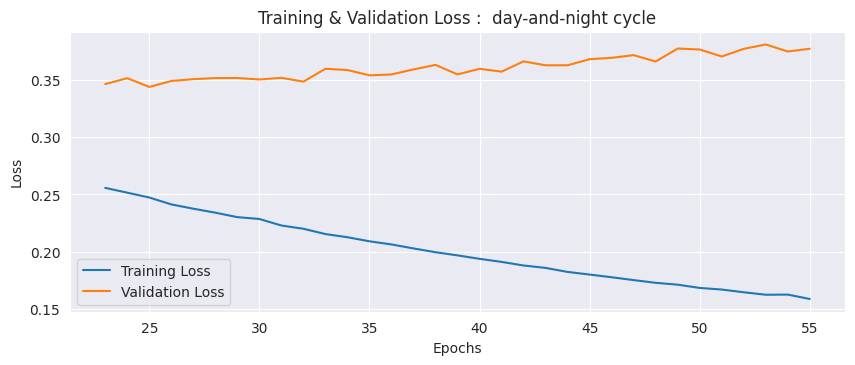

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_cycle, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_cycle, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  day-and-night cycle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
tf_model_cycle.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_cycle_55ep.h5')

#### Erreur sur les anomalies

In [ ]:
tf_model_anomalies = tf.keras.models.load_model('/content/drive/MyDrive/inrae/mymodels/tf_lstm_anomalies.h5',custom_objects={'loss': loss_anomalies})

In [ ]:
tf_model_anomalies.compile(optimizer='adam', loss=loss_anomalies)

In [ ]:
%time history_anomalies = tf_model_anomalies.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[early_stopping],verbose=0)

CPU times: user 22min 18s, sys: 30.9 s, total: 22min 49s
Wall time: 21min 46s


In [ ]:
train_loss = history_anomalies.history['loss']
val_loss = history_anomalies.history['val_loss']

data_anomalies = pd.DataFrame({'Epochs': range(10, len(train_loss)+10),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

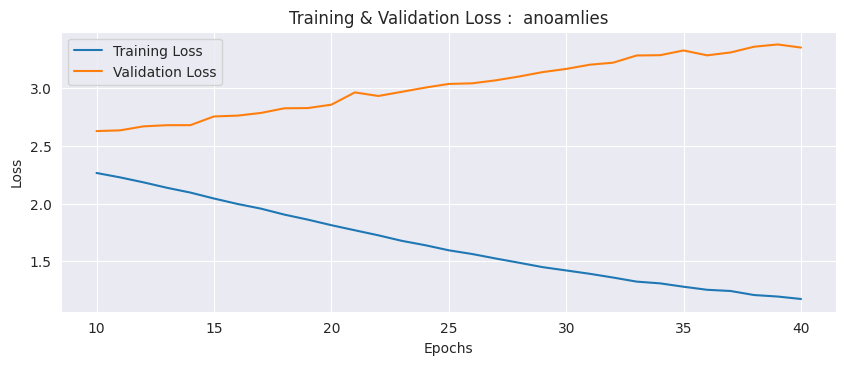

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_anomalies, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_anomalies, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  anoamlies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# globalement entrainé sur 9+31=40 époques
tf_model_anomalies.save('/content/drive/MyDrive/inrae/mymodels/tf_lstm_anomalies_40ep.h5')

### Entrainer le modèle d'un seul coup :p

#### Erreur sur la composante annuelle

In [ ]:
# entrainement sur 50 époques
n_epochs=50

In [ ]:
path_ann = '/content/drive/MyDrive/inrae/mymodels/best_tf_lstm_ann_{epoch:02d}_L365.h5'
checkpoint = ModelCheckpoint(path_ann, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
tf_model_ann = mymodel(hidden_units, sequence_length, features, nbr_sorties)
tf_model_ann.compile(optimizer=optimizer, loss=loss_ann)
%time history_ann = tf_model_ann.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[checkpoint],verbose=0)

CPU times: user 32min 19s, sys: 47.4 s, total: 33min 7s
Wall time: 33min 25s


In [ ]:
train_loss = history_ann.history['loss']
val_loss = history_ann.history['val_loss']

data_ann = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

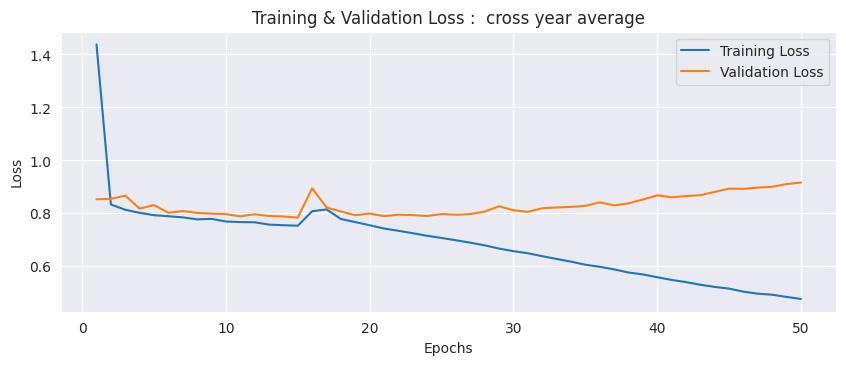

In [ ]:
plt.figure(figsize=(10, 8))

#Courbes loss, training vs validation
plt.subplot(2, 1, 1)
sns.lineplot(data=data_ann, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_ann, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  cross year average')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_val_loss = min(history_ann.history['val_loss'])
best_epoch = history_ann.history['val_loss'].index(best_val_loss)+1
print(f"Le best modèle a été sauvegardé à l'époque {best_epoch} avec un loss de {best_val_loss}" )

Le best modèle a été sauvegardé à l'époque 15 avec un loss de 0.7839298248291016


#### Erreur sur la composante cyclique

In [ ]:
path_cycle = '/content/drive/MyDrive/inrae/mymodels/best_tf_lstm_cycle_{epoch:02d}_L365.h5'
checkpoint = ModelCheckpoint(path_cycle, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
tf_model_cycle = mymodel(hidden_units, sequence_length, features, nbr_sorties)
tf_model_cycle.compile(optimizer=optimizer, loss=loss_cycle)
%time history_cycle = tf_model_cycle.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[checkpoint],verbose=0)

CPU times: user 33min 12s, sys: 45.9 s, total: 33min 58s
Wall time: 33min 27s


In [ ]:
train_loss = history_cycle.history['loss']
val_loss = history_cycle.history['val_loss']

data_cycle = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

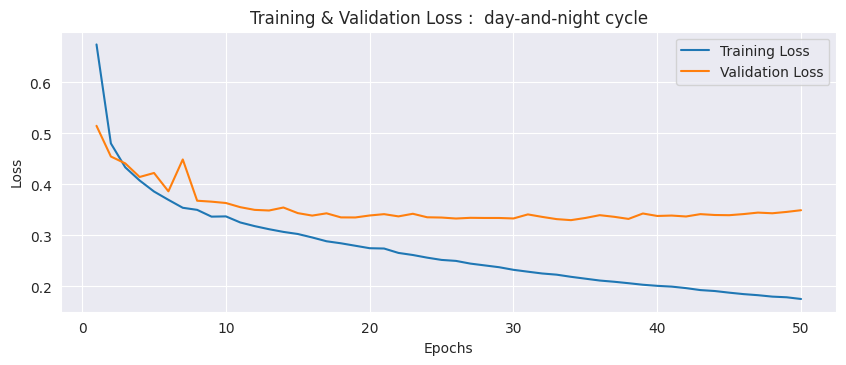

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_cycle, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_cycle, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  day-and-night cycle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_val_loss = min(history_cycle.history['val_loss'])
best_epoch = history_cycle.history['val_loss'].index(best_val_loss)+1
print(f"Le best modèle a été sauvegardé à l'époque {best_epoch} avec un loss de {best_val_loss}" )

Le best modèle a été sauvegardé à l'époque 34 avec un loss de 0.3300819396972656


In [ ]:
path_anomalies = '/content/drive/MyDrive/inrae/mymodels/best_tf_lstm_anomalies_{epoch:02d}_L365.h5'
checkpoint = ModelCheckpoint(path_anomalies, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
tf_model_anomalies = mymodel(hidden_units, sequence_length, features, nbr_sorties)
tf_model_anomalies.compile(optimizer=optimizer, loss=loss_anomalies)

In [ ]:
%time history_anomalies = tf_model_anomalies.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[checkpoint],verbose=0)

CPU times: user 33min 55s, sys: 46.3 s, total: 34min 41s
Wall time: 33min 21s


In [ ]:
train_loss = history_anomalies.history['loss']
val_loss = history_anomalies.history['val_loss']

data_anomalies = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

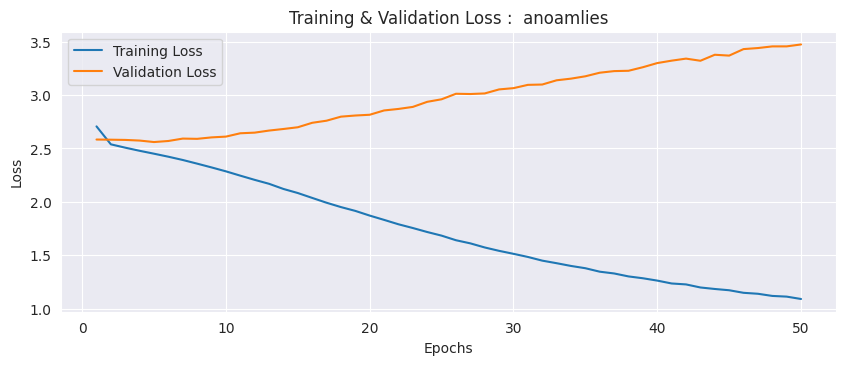

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_anomalies, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_anomalies, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  anoamlies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_val_loss = min(history_anomalies.history['val_loss'])
best_epoch = history_anomalies.history['val_loss'].index(best_val_loss)+1
print(f"Le best modèle a été sauvegardé à l'époque {best_epoch} avec un loss de {best_val_loss}" )

Le best modèle a été sauvegardé à l'époque 5 avec un loss de 2.5599148273468018


## Réentrainer le modèle
en changeant L:la longueur de la séquence de L=365 à L=700 (tout en maintenant les hyperparamètres inchangés)


In [ ]:
# hyperparamètres
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
n_epochs = 50
batch_size = 32

### Erreur sur la composante annuelle

In [ ]:
sequence_length=700 # 15jours

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inputs_outputs(sequence_length, df)[0], inputs_outputs(sequence_length, df)[1], test_size=0.2, random_state=19)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((95784, 700, 7), (23947, 700, 7), (95784, 3), (23947, 3))

In [ ]:
nbr_sorties = 3
hidden_units = 128
sequence_length = 700
features = 7
tf_model = mymodel(hidden_units, sequence_length, features, nbr_sorties)
tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 70,019
Trainable params: 70,019
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/inrae/mymodels/best_tf_lstm_ann_50ep_L700.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
tf_model_ann = mymodel(hidden_units, sequence_length, features, nbr_sorties)
tf_model_ann.compile(optimizer=optimizer, loss=loss_ann)
%time history_ann = tf_model_ann.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[checkpoint],verbose=0)

CPU times: user 54min 31s, sys: 52.3 s, total: 55min 23s
Wall time: 56min 44s


In [ ]:
train_loss = history_ann.history['loss']
val_loss = history_ann.history['val_loss']

data_ann = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})
data_ann.head()

,Epochs,Training Loss,Validation Loss
0,1,1.475327,0.882513
1,2,0.836429,0.835569
2,3,0.814031,0.823787
3,4,0.800524,0.815263
4,5,0.787240,0.805900


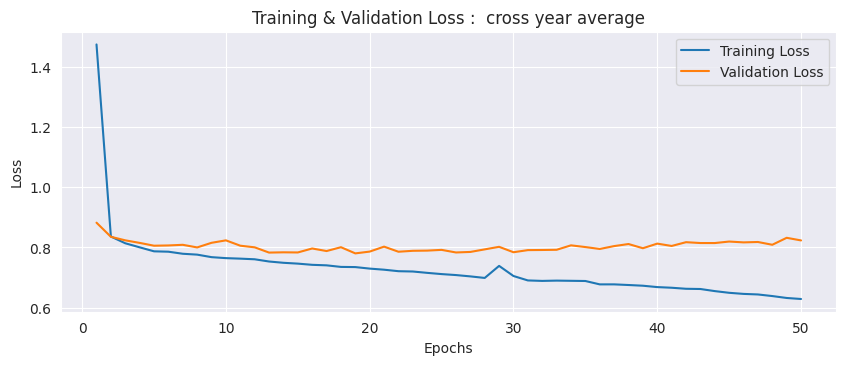

In [ ]:
plt.figure(figsize=(10, 8))

#Courbes loss, training vs validation
plt.subplot(2, 1, 1)
sns.lineplot(data=data_ann, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_ann, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  cross year average')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_val_loss = min(history_ann.history['val_loss'])
best_epoch = history_ann.history['val_loss'].index(best_val_loss)+1
print(f"Le best modèle a été sauvegardé à l'époque {best_epoch} avec un loss de  {best_val_loss}" )

Le best modèle a été sauvegardé à l'époque 19 avec un loss de  0.7803762555122375


### Erreur sur la composante du cycle

In [ ]:
path_cycle = '/content/drive/MyDrive/inrae/mymodels/best_tf_lstm_cycle_{epoch:02d}_L700.h5'
checkpoint = ModelCheckpoint(path_cycle, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
tf_model_cycle = mymodel(hidden_units, sequence_length, features, nbr_sorties)
tf_model_cycle.compile(optimizer=optimizer, loss=loss_cycle)
%time history_cycle = tf_model_cycle.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[checkpoint],verbose=0)

CPU times: user 52min 43s, sys: 50.4 s, total: 53min 34s
Wall time: 55min 27s


In [ ]:
train_loss = history_cycle.history['loss']
val_loss = history_cycle.history['val_loss']

data_cycle = pd.DataFrame({'Epochs': range(23, len(train_loss)+23),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

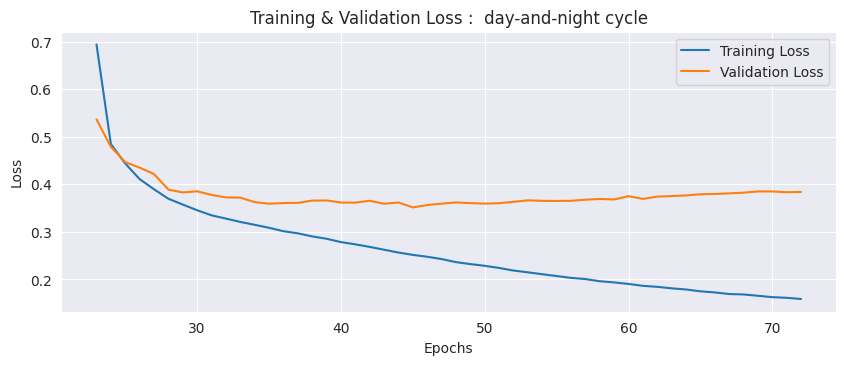

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_cycle, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_cycle, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  day-and-night cycle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_val_loss = min(history_cycle.history['val_loss'])
best_epoch = history_cycle.history['val_loss'].index(best_val_loss)+1
print(f"Le best modèle a été sauvegardé à l'époque {best_epoch} avec un loss de {best_val_loss}" )

Le best modèle a été sauvegardé à l'époque 23 avec un loss de  0.3515114486217499


### Erreur sur les anomalies

In [ ]:
path_anomalies = '/content/drive/MyDrive/inrae/mymodels/best_tf_lstm_anomalies_{epoch:02d}_L700.h5'
checkpoint = ModelCheckpoint(path_anomalies, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
tf_model_anomalies = mymodel(hidden_units, sequence_length, features, nbr_sorties)
tf_model_anomalies.compile(optimizer=optimizer, loss=loss_anomalies)
%time history_anomalies = tf_model_anomalies.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[checkpoint],verbose=0)

CPU times: user 53min 30s, sys: 52.1 s, total: 54min 22s
Wall time: 56min 6s


In [ ]:
train_loss = history_anomalies.history['loss']
val_loss = history_anomalies.history['val_loss']

data_anomalies = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

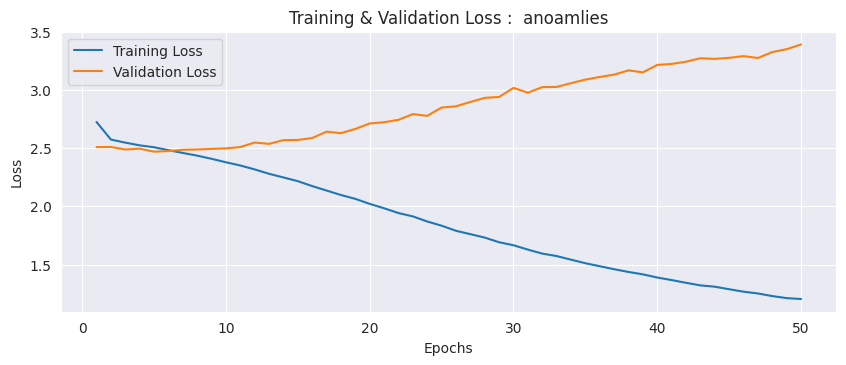

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_anomalies, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_anomalies, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  anoamlies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_val_loss = min(history_anomalies.history['val_loss'])
best_epoch = history_anomalies.history['val_loss'].index(best_val_loss)+1
print(f"Le best modèle a été sauvegardé à l'époque {best_epoch} avec un loss de {best_val_loss}" )

Le best modèle a été sauvegardé à l'époque 5 avec un loss de 2.470036745071411


## Augmenter la complexité du modèle

Dans tout ce qui a précédé, nous avons utilisé un modèle avec une seule couche LSTM avec 128 unités cachées. On introduit cette fois une couche lstm avant avec 64 états cachés et on diminue le taux d'apprentissage (+on double la taille du batch)

In [ ]:
# hyperparamètres
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
n_epochs = 30
batch_size = 64

In [ ]:
def mymodel(sequence_length, features, nbr_sorties):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', return_sequences=True, kernel_initializer='he_normal')) # initialisation poids: distribution normale he
    model.add(Dropout(0.2))
    model.add(LSTM(128,activation='tanh',return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(nbr_sorties))
    return model

In [ ]:
nbr_sorties = 3
sequence_length = 365
features = 7
tf_model = mymodel(sequence_length, features, nbr_sorties)
tf_model.build(input_shape=(None, sequence_length, features))
tf_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 365, 64)           18432     
                                                                 
 dropout_24 (Dropout)        (None, 365, 64)           0         
                                                                 
 lstm_19 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 3)                 387       
                                                                 
Total params: 117,635
Trainable params: 117,635
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_anomalies = '/content/drive/MyDrive/inrae/mymodels/best_tf_lstm_anomalies_{epoch:02d}_L365_7Lay.h5'
checkpoint = ModelCheckpoint(path_anomalies, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
tf_model_anomalies = mymodel(sequence_length, features, nbr_sorties)
tf_model_anomalies.compile(optimizer=optimizer, loss=loss_anomalies)
%time history_anomalies = tf_model_anomalies.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[checkpoint],verbose=0)

CPU times: user 21min, sys: 25.1 s, total: 21min 25s
Wall time: 22min 27s


In [ ]:
train_loss = history_anomalies.history['loss']
val_loss = history_anomalies.history['val_loss']

data_anomalies = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

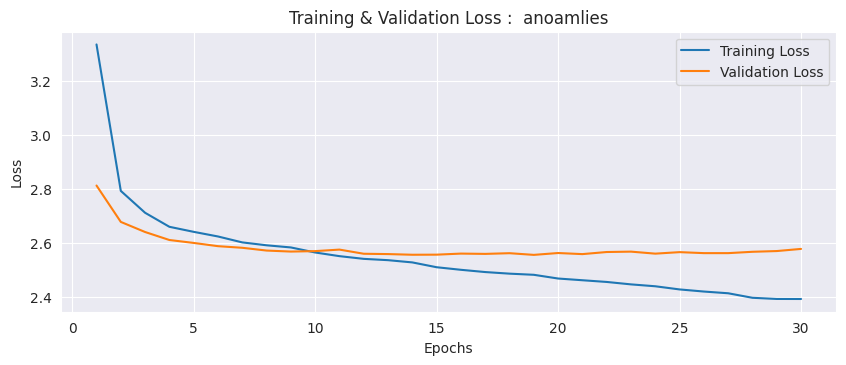

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_anomalies, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_anomalies, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  anoamlies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_val_loss = min(history_anomalies.history['val_loss'])
best_epoch = history_anomalies.history['val_loss'].index(best_val_loss)+1
print(f"Le best modèle a été sauvegardé à l'époque {best_epoch} avec un loss de {best_val_loss}" )

Le best modèle a été sauvegardé à l'époque 19 avec un loss de 2.5560874938964844


Même architecture mais on diminue davantage le taux d'apprentissage et on augmente le batch size.

In [ ]:
learning_rate = 0.00001
batch_size = 80

In [ ]:
path_anomalies = '/content/drive/MyDrive/inrae/mymodels/best_tf_lstm_anomalies_{epoch:02d}_L365_7Lay_bs80.h5'
checkpoint = ModelCheckpoint(path_anomalies, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
tf_model_anomalies = mymodel(sequence_length, features, nbr_sorties)
tf_model_anomalies.compile(optimizer=optimizer, loss=loss_anomalies)
%time history_anomalies = tf_model_anomalies.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[checkpoint],verbose=0)

CPU times: user 18min 8s, sys: 23.8 s, total: 18min 32s
Wall time: 19min 30s


In [ ]:
train_loss = history_anomalies.history['loss']
val_loss = history_anomalies.history['val_loss']

data_anomalies = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

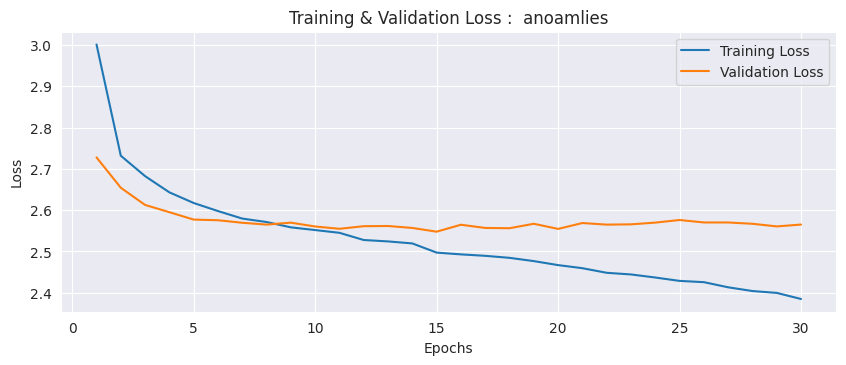

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_anomalies, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_anomalies, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  anoamlies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Autre architecture

Maintenant on va introduire une nouvelle architecture de deux couches lstm avec 64 états cachés.

In [ ]:
# hyperparamètres
n_epochs = 50
batch_size = 64

In [ ]:
def mymodel(sequence_length, features, nbr_sorties):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', return_sequences=True, kernel_initializer='he_normal')) # initialisation poids: distribution normale he
    model.add(Dropout(0.2))
    model.add(LSTM(64,activation='tanh',return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(nbr_sorties))
    return model

In [ ]:
nbr_sorties = 3
sequence_length = 365
features = 7
tf_model = mymodel(sequence_length, features, nbr_sorties)
tf_model.build(input_shape=(None, sequence_length, features))
tf_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 365, 64)           18432     
                                                                 
 dropout_2 (Dropout)         (None, 365, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 51,651
Trainable params: 51,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import AdamW

learning_rate = 0.0001
weight_decay = 0.01
optimizer = AdamW(learning_rate=learning_rate, weight_decay=weight_decay,amsgrad=True) # utiliser AMSGrad

In [ ]:
path_anomalies = '/content/drive/MyDrive/inrae/mymodels/best_tf_lstm_anomalies_{epoch:02d}_L365_AdamW_64x2.h5'
checkpoint = ModelCheckpoint(path_anomalies, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [ ]:
tf_model_anomalies = mymodel(sequence_length, features, nbr_sorties)
tf_model_anomalies.compile(optimizer=optimizer, loss=loss_anomalies)
tf_model_anomalies.build(input_shape=(None, sequence_length, features))
tf_model_anomalies.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 365, 64)           18432     
                                                                 
 dropout_10 (Dropout)        (None, 365, 64)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 51,651
Trainable params: 51,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%time history_anomalies = tf_model_anomalies.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[checkpoint],verbose=0)

CPU times: user 32min 35s, sys: 40.3 s, total: 33min 15s
Wall time: 32min 27s


In [ ]:
train_loss = history_anomalies.history['loss']
val_loss = history_anomalies.history['val_loss']

data_anomalies = pd.DataFrame({'Epochs': range(1, len(train_loss)+1),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

In [ ]:
# train_loss = [3.408796548843384, 2.8281588554382324, 2.742466926574707, 2.6930782794952393, 2.661471366882324, 2.6357216835021973, 2.6188724040985107, 2.6149706840515137, 2.605645179748535, 2.5912997722625732, 2.5846829414367676, 2.57635498046875, 2.572408437728882, 2.5678465366363525, 2.5655109882354736, 2.5503032207489014, 2.551482915878296, 2.537287473678589, 2.5308151245117188, 2.537527322769165, 2.520418405532837, 2.51753306388855, 2.5104904174804688, 2.5142791271209717, 2.5043656826019287, 2.499849319458008, 2.488731622695923, 2.492082357406616, 2.4868733882904053, 2.4864678382873535, 2.4782345294952393, 2.4685304164886475, 2.4707696437835693, 2.4628045558929443, 2.4560024738311768, 2.4592537879943848, 2.458498477935791, 2.4493465423583984, 2.449737310409546, 2.441392183303833, 2.432346820831299, 2.429786205291748, 2.4283673763275146, 2.4214835166931152, 2.4135963916778564, 2.4121694564819336, 2.4087929725646973, 2.402925491333008, 2.3991546630859375, 2.391864538192749]
# val_loss = [2.8742403984069824, 2.7171313762664795, 2.6703505516052246, 2.634033679962158, 2.613870620727539, 2.6002607345581055, 2.5919058322906494, 2.583667039871216, 2.587907075881958, 2.576688766479492, 2.568571090698242, 2.5673091411590576, 2.564248561859131, 2.5620243549346924, 2.5602786540985107, 2.5635628700256348, 2.5621120929718018, 2.5627217292785645, 2.5610334873199463, 2.5667781829833984, 2.558553457260132, 2.556948661804199, 2.5566723346710205, 2.5562164783477783, 2.561617612838745, 2.5543508529663086, 2.5658624172210693, 2.5632522106170654, 2.5656635761260986, 2.562260389328003, 2.5598134994506836, 2.5717620849609375, 2.569934129714966, 2.5646889209747314, 2.5683646202087402, 2.5758111476898193, 2.5678327083587646, 2.5752766132354736, 2.5740573406219482, 2.5755913257598877, 2.5797371864318848, 2.587195634841919, 2.5794379711151123, 2.587012767791748, 2.5856170654296875, 2.5916876792907715, 2.5925369262695312, 2.5907623767852783, 2.584967613220215, 2.593742609024048]

[3.408796548843384, 2.8281588554382324, 2.742466926574707, 2.6930782794952393, 2.661471366882324, 2.6357216835021973, 2.6188724040985107, 2.6149706840515137, 2.605645179748535, 2.5912997722625732, 2.5846829414367676, 2.57635498046875, 2.572408437728882, 2.5678465366363525, 2.5655109882354736, 2.5503032207489014, 2.551482915878296, 2.537287473678589, 2.5308151245117188, 2.537527322769165, 2.520418405532837, 2.51753306388855, 2.5104904174804688, 2.5142791271209717, 2.5043656826019287, 2.499849319458008, 2.488731622695923, 2.492082357406616, 2.4868733882904053, 2.4864678382873535, 2.4782345294952393, 2.4685304164886475, 2.4707696437835693, 2.4628045558929443, 2.4560024738311768, 2.4592537879943848, 2.458498477935791, 2.4493465423583984, 2.449737310409546, 2.441392183303833, 2.432346820831299, 2.429786205291748, 2.4283673763275146, 2.4214835166931152, 2.4135963916778564, 2.4121694564819336, 2.4087929725646973, 2.402925491333008, 2.3991546630859375, 2.391864538192749]
[2.8742403984069824, 2

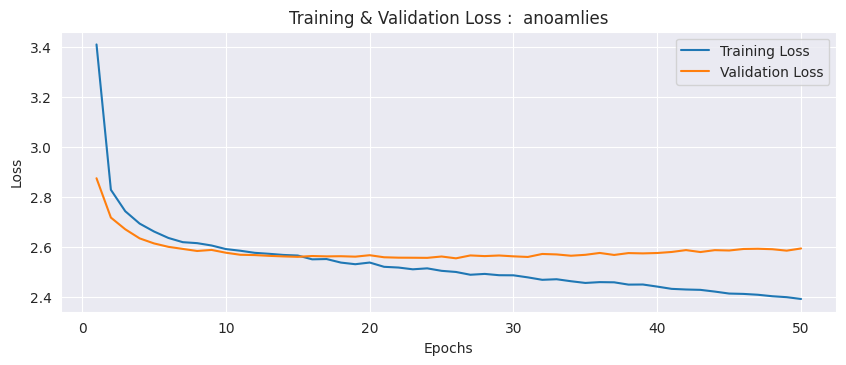

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_anomalies, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_anomalies, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  anoamlies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
%time history_anomalies_2 = tf_model_anomalies.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[checkpoint],verbose=0)

CPU times: user 32min 5s, sys: 39.5 s, total: 32min 44s
Wall time: 31min 25s


In [ ]:
train_loss = history_anomalies_2.history['loss']
val_loss = history_anomalies_2.history['val_loss']

data_anomalies = pd.DataFrame({'Epochs': range(51, len(train_loss)+51),
                     'Training Loss': train_loss,
                     'Validation Loss': val_loss})

In [ ]:
print(train_loss)
print(val_loss)

[2.382504940032959, 2.39158296585083, 2.3843894004821777, 2.3806304931640625, 2.3747944831848145, 2.3708078861236572, 2.3644585609436035, 2.3652496337890625, 2.3600921630859375, 2.3572497367858887, 2.3548786640167236, 2.3387668132781982, 2.3404369354248047, 2.3369736671447754, 2.336632490158081, 2.327885389328003, 2.321251392364502, 2.31630539894104, 2.3123762607574463, 2.310234546661377, 2.310590982437134, 2.3072104454040527, 2.304137945175171, 2.297938823699951, 2.3031692504882812, 2.285905361175537, 2.2836906909942627, 2.2767786979675293, 2.278855800628662, 2.2711105346679688, 2.2646143436431885, 2.2727725505828857, 2.2662100791931152, 2.25453782081604, 2.2554073333740234, 2.251969814300537, 2.2363905906677246, 2.248781204223633, 2.245121717453003, 2.2405121326446533, 2.232651472091675, 2.2257769107818604, 2.2326107025146484, 2.2132742404937744, 2.2173373699188232, 2.218975305557251, 2.210282802581787, 2.199458360671997, 2.2023589611053467, 2.196699857711792]
[2.6134839057922363, 2.

In [ ]:
train_loss=[2.382504940032959, 2.39158296585083, 2.3843894004821777, 2.3806304931640625, 2.3747944831848145, 2.3708078861236572, 2.3644585609436035, 2.3652496337890625, 2.3600921630859375, 2.3572497367858887, 2.3548786640167236, 2.3387668132781982, 2.3404369354248047, 2.3369736671447754, 2.336632490158081, 2.327885389328003, 2.321251392364502, 2.31630539894104, 2.3123762607574463, 2.310234546661377, 2.310590982437134, 2.3072104454040527, 2.304137945175171, 2.297938823699951, 2.3031692504882812, 2.285905361175537, 2.2836906909942627, 2.2767786979675293, 2.278855800628662, 2.2711105346679688, 2.2646143436431885, 2.2727725505828857, 2.2662100791931152, 2.25453782081604, 2.2554073333740234, 2.251969814300537, 2.2363905906677246, 2.248781204223633, 2.245121717453003, 2.2405121326446533, 2.232651472091675, 2.2257769107818604, 2.2326107025146484, 2.2132742404937744, 2.2173373699188232, 2.218975305557251, 2.210282802581787, 2.199458360671997, 2.2023589611053467, 2.196699857711792]
val_loss=[2.6134839057922363, 2.588244676589966, 2.601085901260376, 2.60448956489563, 2.59249210357666, 2.6020617485046387, 2.5969958305358887, 2.5992062091827393, 2.5934267044067383, 2.5978996753692627, 2.599351406097412, 2.6191935539245605, 2.607445478439331, 2.6236937046051025, 2.5980334281921387, 2.6082370281219482, 2.6139039993286133, 2.6330127716064453, 2.6128079891204834, 2.6111249923706055, 2.613166332244873, 2.5991969108581543, 2.614574670791626, 2.61245059967041, 2.612741470336914, 2.613283157348633, 2.608874797821045, 2.623039484024048, 2.6038272380828857, 2.62373685836792, 2.6188125610351562, 2.6293652057647705, 2.6191587448120117, 2.616442918777466, 2.6197571754455566, 2.5911214351654053, 2.610813856124878, 2.6276118755340576, 2.617722988128662, 2.6131420135498047, 2.621682643890381, 2.6287310123443604, 2.6086997985839844, 2.6349518299102783, 2.627303123474121, 2.6269900798797607, 2.6324777603149414, 2.626945734024048, 2.640047788619995, 2.6134631633758545]


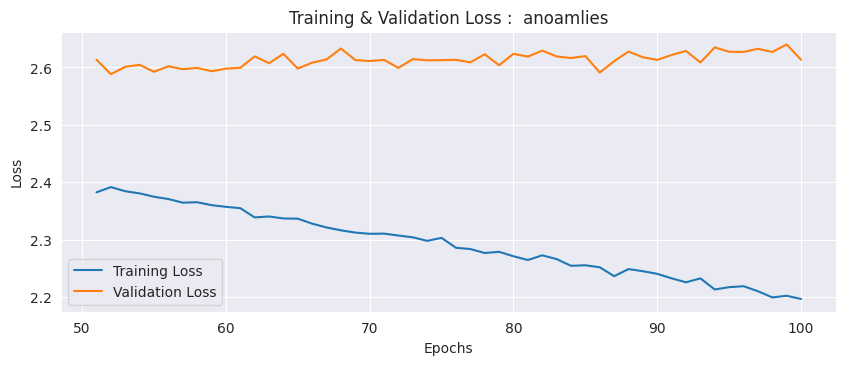

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=data_anomalies, x='Epochs', y='Training Loss', label='Training Loss')
sns.lineplot(data=data_anomalies, x='Epochs', y='Validation Loss', label='Validation Loss')
plt.title('Training & Validation Loss :  anoamlies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
tf_model_cycle = tf.keras.models.load_model('/content/drive/MyDrive/inrae/mymodels/tf_lstm_cycle.h5',custom_objects={'loss': loss_cycle})